<a href="https://colab.research.google.com/github/ividal/ml-on-aws/blob/master/disaster_tweets_with_BlazingText.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real disaster or fake?
------------

## Problem statement 

One very positive use of Twitter can be to monitor for grave problems and alert authorities. However, many of these could be users exaggerating every day issues or simply describing negative events - just not something worth alerting the national guard about.

This project will cover work on an open dataset that helps with this issue: from data exploration, to its cleaning up and pre-processing, so that it can be ingested by AWS SageMaker's BlazingText to train a Word2Vec model.



## Credits

Much of the work here, from analysis techniques to the training, has been learnt and shamelessly plucked from the following (extremely helpful!) sources:
* [NLP with Disaster Tweets: EDA+NLP+XGBoost](https://www.kaggle.com/akihironomura/nlp-with-disaster-tweets-eda-nlp-xgboost)
* [Basic EDA, Cleaning and GloVe](https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove)
* [Blazingtext Text Classification Dbpedia](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/blazingtext_text_classification_dbpedia/blazingtext_text_classification_dbpedia.ipynb)

Thank you for your help!


## Data analysis

Although one could potentially attempt to collect a custom dataset for this problem, there already is an open dataset, called "Disaster Tweets", which can serve as starting point.

The dataset can be obtained here(https://www.kaggle.com/c/nlp-getting-started).

From the get-go, we can see using this dataset has two very immediate drawbacks: 

1. it will be somewhat generic, that is, if our usecase were specific to some problem (e.g. bomb threats), this dataset would be too generic. 
2. the dataset is not particularly big.


Having said this, there are other major advantages of using the dataset:
1. techniques applied here can easily be translated to related tasks.
2. It is big enough that results can be assumed to represent what those same techniques could achieve on a more general setting.
3. The dataset is in a single language (English), which means we can use one language model, one set of stop words, etc.


In [70]:
import string
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [71]:
df_train = pd.read_csv('train.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('test.csv', dtype={'id': np.int16})

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))



Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.20 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.08 MB


As mentioned, only roughly 7600 samples in the training dataset. Each has 5 features:

In [72]:
df_train.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


#### Columns

id - a unique identifier for each tweet

text - the text of the tweet

location - the location the tweet was sent from (may be blank)

keyword - a particular keyword from the tweet (may be blank)

target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)




Now the test dataset does not have the target, which makes sense. This is important if we plan to compare algorithms: the validation set will have to come as a split of the training set.



In [73]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Let's see how many of the entries have empty locations or keywords.

In [74]:
df_train["location"].isnull().value_counts()/df_train.shape[0]

False    0.66728
True     0.33272
Name: location, dtype: float64

In [75]:
df_train["keyword"].isnull().value_counts()/df_train.shape[0]

False    0.991987
True     0.008013
Name: keyword, dtype: float64

Are the critial data (text or target) missing?


In [76]:
df_train['text'].isnull().value_counts() / df_train.shape[0]

False    1.0
Name: text, dtype: float64

In [77]:
df_train['target'].isnull().value_counts() / df_train.shape[0]

False    1.0
Name: target, dtype: float64

What about in test?


In [78]:
df_test['text'].isnull().value_counts() / df_test.shape[0]

False    1.0
Name: text, dtype: float64

In [79]:
df_test['keyword'].isnull().value_counts() / df_test.shape[0]

False    0.992032
True     0.007968
Name: keyword, dtype: float64

## Feature Engineering

### Dropping features?

From what we saw above, most of the entries do have a keyword. However at inference time we may not always have this information, even if it's present in the test set: do Twitter users typically provide this? We'll not rely on it.

As for location, we could explore using it as follows:
1. First do a baseline with only the raw tweets, without location.
2. Do a separate dataset where we keep the locaiton information. BlazingText would not be able to ingest this, but we could train Word2Vec separately and then use other algorithms, such as XGBoost for the classification.

For now, we will proceed with the first approach (without location).

We will do three things to the training data, before training on it:

* Clean up items like mentiones, stop words, emojis and other symbols that could make a model choke.
* Remove the header from the input file.
* Keep only the label and the clean text, as for now we will do nothing with location and/or given keyword. We will let the model(s) learn the features from the text itself.

### Data balance?

It's important to see how balanced our data is:


<function matplotlib.pyplot.show>

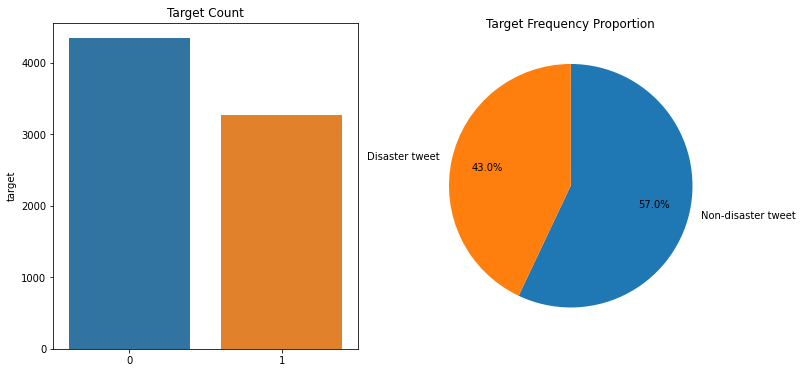

In [80]:
# Target Distribution (0 or 1)
dist_class = df_train['target'].value_counts()
labels = ['Non-disaster tweet', 'Disaster tweet']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

sns.barplot(x=dist_class.index, y=dist_class, ax=ax1).set_title("Target Count")

ax2.pie(dist_class,
        labels=labels,
        counterclock=False,
        startangle=90,
        autopct='%1.1f%%',
        pctdistance=0.7)
plt.title("Target Frequency Proportion")
plt.show

This is fairly balanced, so we can afford to not try to correct this. (We also don't know how this relates to a real world scenario: would a dataset more biased towards non-real disasters reflect reality better?

To answer this we should either work with a dataset containing all sorts of tweets, without filtering for perceived disasters (fake or not). Otherwise, we could take a further step and deploy a trained model in the wild and see how it performs.

For now, we'll accept the class distribution as it is and not worry about bias.

### Derived features?

Could we use other features, like tweet length?



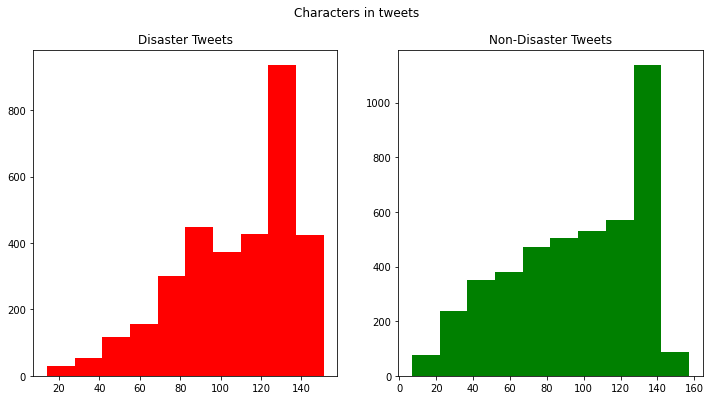

In [81]:
disaster_tweet_length = df_train[df_train['target']==1]['text'].str.len()
nondisaster_tweet_length = df_train[df_train['target']==0]['text'].str.len()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

ax1.hist(disaster_tweet_length, color='red')
ax1.set_title("Disaster Tweets")

ax2.hist(nondisaster_tweet_length, color='green')
ax2.set_title("Non-Disaster Tweets")

fig.suptitle("Characters in tweets")
plt.show()

It looks like not in general. At best, we could only argue extremely long tweets tend not to be real disaster tweets, but it's a flimsy insight at best.

So, to recap, let's stick to what BlazingText and Word2Vec can learn from the text itself.

### Data cleaning

Let's focus on 4 specific text pests, specially in tweets: emojis, URLs, other html and punctuation.

Enter NLTK for our text pre-processing needs.

In [82]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from nltk.stem.porter import *
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [83]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r' ',text)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r' ',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"[^\x00-\x7f]"
                           "]+", flags=re.UNICODE)
    clean = emoji_pattern.sub(r' ', text)
    minus_nonascii = re.sub(r'[^\x00-\x7f]',r' ',clean) # remove non-ascii    
    return minus_nonascii

def remove_punc(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)





It could be debatable what role online slang plays, but the safest route is to remove it:

In [84]:
# Source: https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt
slang_abbrev_dict = {
    'AFAIK': 'As Far As I Know',
    'AFK': 'Away From Keyboard',
    'ASAP': 'As Soon As Possible',
    'ATK': 'At The Keyboard',
    'ATM': 'At The Moment',
    'A3': 'Anytime, Anywhere, Anyplace',
    'BAK': 'Back At Keyboard',
    'BBL': 'Be Back Later',
    'BBS': 'Be Back Soon',
    'BFN': 'Bye For Now',
    'B4N': 'Bye For Now',
    'BRB': 'Be Right Back',
    'BRT': 'Be Right There',
    'BTW': 'By The Way',
    'B4': 'Before',
    'B4N': 'Bye For Now',
    'CU': 'See You',
    'CUL8R': 'See You Later',
    'CYA': 'See You',
    'FAQ': 'Frequently Asked Questions',
    'FC': 'Fingers Crossed',
    'FWIW': 'For What It\'s Worth',
    'FYI': 'For Your Information',
    'GAL': 'Get A Life',
    'GG': 'Good Game',
    'GN': 'Good Night',
    'GMTA': 'Great Minds Think Alike',
    'GR8': 'Great!',
    'G9': 'Genius',
    'IC': 'I See',
    'ICQ': 'I Seek you',
    'ILU': 'I Love You',
    'IMHO': 'In My Humble Opinion',
    'IMO': 'In My Opinion',
    'IOW': 'In Other Words',
    'IRL': 'In Real Life',
    'KISS': 'Keep It Simple, Stupid',
    'LDR': 'Long Distance Relationship',
    'LMAO': 'Laugh My Ass Off',
    'LOL': 'Laughing Out Loud',
    'LTNS': 'Long Time No See',
    'L8R': 'Later',
    'MTE': 'My Thoughts Exactly',
    'M8': 'Mate',
    'NRN': 'No Reply Necessary',
    'OIC': 'Oh I See',
    'OMG': 'Oh My God',
    'PITA': 'Pain In The Ass',
    'PRT': 'Party',
    'PRW': 'Parents Are Watching',
    'QPSA?': 'Que Pasa?',
    'ROFL': 'Rolling On The Floor Laughing',
    'ROFLOL': 'Rolling On The Floor Laughing Out Loud',
    'ROTFLMAO': 'Rolling On The Floor Laughing My Ass Off',
    'SK8': 'Skate',
    'STATS': 'Your sex and age',
    'ASL': 'Age, Sex, Location',
    'THX': 'Thank You',
    'TTFN': 'Ta-Ta For Now!',
    'TTYL': 'Talk To You Later',
    'U': 'You',
    'U2': 'You Too',
    'U4E': 'Yours For Ever',
    'WB': 'Welcome Back',
    'WTF': 'What The Fuck',
    'WTG': 'Way To Go!',
    'WUF': 'Where Are You From?',
    'W8': 'Wait',
    '7K': 'Sick:-D Laugher'
}

def unslang(text):
    if text.upper() in slang_abbrev_dict.keys():
        return slang_abbrev_dict[text.upper()]
    else:
        return text

Additionally, we still will have to tokenize, stem and remove stopwords.

In [85]:
def tokenization(text):
    text = re.split('\W+', text)
    return text

stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

def stemming(text):
    text = [stemmer.stem(word) for word in text]
    return text
    

Now we can apply all of the cleaning tools above to each entry:

In [86]:
df_train['cleaned_text'] = df_train['text'].apply(lambda x : remove_url(x))
df_train['cleaned_text'] = df_train['cleaned_text'].apply(lambda x : remove_html(x))
df_train['cleaned_text'] = df_train['cleaned_text'].apply(lambda x : remove_emoji(x))
df_train['cleaned_text'] = df_train['cleaned_text'].apply(lambda x : unslang(x))
df_train['cleaned_text'] = df_train['cleaned_text'].apply(lambda x : remove_punc(x))
df_train['cleaned_text'] = df_train['cleaned_text'].apply(lambda x : tokenization(x.lower()))
df_train['cleaned_text'] = df_train['cleaned_text'].apply(lambda x : remove_stopwords(x))
df_train['cleaned_text'] = df_train['cleaned_text'].apply(lambda x : stemming(x))
df_train['cleaned_text'] = df_train['cleaned_text'].apply(lambda x : ' '.join(x))

We have now added the clean text as a separate feature, which is what we will truly train Word2Vec on. Notice, however, that this in no way affects the class distribution, as no entries have been removed.

In [87]:
clean = df_train[["target", "cleaned_text"]]
clean.head()

,target,cleaned_text
0,1,deed reason earthquak may allah forgiv us
1,1,forest fire near la rong sask canada
2,1,resid ask shelter place notifi offic evacu she...
3,1,13000 peopl receiv wildfir evacu order califor...
4,1,got sent photo rubi alaska smoke wildfir pour ...


In [88]:
print(clean.info())
clean['target'].isnull().value_counts() / df_train.shape[0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   target        7613 non-null   int8  
 1   cleaned_text  7613 non-null   object
dtypes: int8(1), object(1)
memory usage: 67.0+ KB
None


False    1.0
Name: target, dtype: float64

## Data pre-processing for AWS SageMaker BlazingText

Since we won't be able to use the (unlabelled) test set for validation, let's first split the current training set into train and validation.



In [89]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(clean, test_size=0.2, random_state=42)

print(f"Final training set: {train.shape}")
print(f"Final validation set: {val.shape}")


Final training set: (6090, 2)
Final validation set: (1523, 2)


Let's freeze this dataset now, since it's what we will be using for all experiments from now on.

In [90]:
train.to_csv("split_train.csv", index=False)
val.to_csv("split_val.csv", index=False)

Next, we'll have to follow the format described [in the AWS documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html#bt-inputoutput): one text entry per line, with two elements: the (prefixed) label and the clean text, separated by a space.

In [91]:
from random import shuffle
import multiprocessing
from multiprocessing import Pool
import csv
import re

In [92]:
def transform_instance(row):
    cur_row = []
    #AWS doc states we need to Prefix the label with "__label__"
    cur_row = f"__label__{row[0]} {row[1]}"
    return cur_row

In [101]:
def preprocess(input_file, output_file, keep=1):
    all_rows = []
    with open(input_file, 'r') as csvinfile:
        csv_reader = csv.reader(csvinfile, delimiter=',')
        next(csv_reader)
        for i,row in enumerate(csv_reader):
            all_rows.append(row)

    shuffle(all_rows)
    all_rows = all_rows[:int(keep*len(all_rows))]
    pool = Pool(processes=multiprocessing.cpu_count())
    transformed_rows = pool.map(transform_instance, all_rows)
    pool.close() 
    pool.join()
    print(transformed_rows[100:150])
    
    with open(output_file, 'w') as outfile:
      for r in transformed_rows:
        outfile.writelines(f"{r}\n")


In [102]:
preprocess('split_train.csv', 'tweets_train.txt')
preprocess('split_val.csv', 'tweets_val.txt')


['__label__1 powerlin tram gc highway passeng evacu 9newsbrisban 9newsgoldcoast ', '__label__1 rescuer found bare aliv idea allerg ', '__label__0 eganator2000 arent mani obliter server alway like play', '__label__1 drunk meal 101 cook your total obliter ', '__label__1 unr continu sever thunderstorm warn wind 60 mph hail lt75 weston w custer fall river pennington till 715 p ', '__label__0 need life sin girlfriend ride till bloodi end girlfriend', '__label__0 well feel like im fire', '__label__1 sterlingscott red carpet fundrais oso mudslid ', '__label__1 cspanwj 90blksamp8wht collud 2 take wht f usagov auth hostageamp2 make look blk wbioterrorismampus lglorg idi id still', '__label__0 darrylb1979 yea heard thatnot come 2017 2019 vampiro bleed', '__label__0 wftv eyewit news fbi man stole us secret marri honduran minor sex ', '__label__1 wake kern counti eyewit news morn air right kbak cbs29 liveonkbak ', '__label__1 sadli tent fli surviv hailstorm tear roof water tent ', '__label__0 cycl

## ML Algorithm Tuning & Testing

This section was carried out completely on AWS SageMaker.

Notice BlazingText will report validation accuracy when provided with a `validation` channel.


Several models were trained, all based on BlazingText, tweaking the number of epochs: 1, 5, 10.

Additionally, a separate experiment was done on the vector dimensions, using both 50-dim and the default 100-dim vectors with 5 and 10 epochs.

Overall, the best result both on the training and validation sets was 50-dim vectors with 10 epochs (training accuracy = 0.9458), which was slightly better than 100-dim (0.9338). 

On the validation set, the results were the same for both 100-dim and 50-dim (accuracy = 0.7938), suggesting higher dimensionality for this dataset is overkill.

## Next steps

It would be interesting to see a separate embedding training, outside SageMaker's built-in algorithms. For instance, Word2Vec embeddings fed into XGBoost could yield good results.

Additionally, it would also be interesting to know how low we can go in dimensionality before hitting a limit.